Prédire la consommation électrique journalière des régions françaises, en utilisant les données publiques de soutirages électriques (RTE) et les températures (Météo-France), avec différents modèles de Machine Learning (Prophet, CatBoost, LSTM), dans une architecture propre (POO, tests, dashboard, dbt) pour te préparer aux tests techniques et entretiens.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [64]:
os.chdir(r"C:\Users\kadas\Desktop\prevision_dl\data\raw")

In [65]:
def importer_fichiers(dossier):
    df = pd.read_parquet(dossier)
    print("shape du fichier '{dossier}':", df.shape)
    return df

In [66]:
soutirages = importer_fichiers("soutirages-regionaux-quotidiens-consolides-rpt.parquet")
temperatures = importer_fichiers("temperature-quotidienne-departementale.parquet")

shape du fichier '{dossier}': (143846, 57)
shape du fichier '{dossier}': (268800, 6)


In [67]:
# Vérifier les colonnes
print("\nColonnes soutirages:", soutirages.columns.tolist())
print("Colonnes températures:", temperatures.columns.tolist())

# Vérifier valeurs uniques pour les régions/départements
print("\nRégions disponibles:", soutirages['region'].unique()[:10])
print("Départements disponibles:", temperatures['departement'].unique()[:10])



Colonnes soutirages: ['date_de_la_courbe', 'code_insee_region', 'region', 'secteur_activite_economique', 'code_tension', 'libelle_tension', '00h00', '00h30', '01h00', '01h30', '02h00', '02h30', '03h00', '03h30', '04h00', '04h30', '05h00', '05h30', '06h00', '06h30', '07h00', '07h30', '08h00', '08h30', '09h00', '09h30', '10h00', '10h30', '11h00', '11h30', '12h00', '12h30', '13h00', '13h30', '14h00', '14h30', '15h00', '15h30', '16h00', '16h30', '17h00', '17h30', '18h00', '18h30', '19h00', '19h30', '20h00', '20h30', '21h00', '21h30', '22h00', '22h30', '23h00', '23h30', 'nombre_de_points_de_soutirage', 'energie_journaliere', 'qualite']
Colonnes températures: ['date_obs', 'code_insee_departement', 'departement', 'tmin', 'tmax', 'tmoy']



Régions disponibles: ['Auvergne-Rhône-Alpes' 'Bourgogne-Franche-Comté' 'Hauts-de-France'
 'Nouvelle-Aquitaine' "Provence-Alpes-Côte d'Azur" 'Grand Est'
 'Île-de-France' 'Normandie' 'Occitanie' 'Bretagne']
Départements disponibles: ['Territoire de Belfort' 'Moselle' 'Alpes-Maritimes' 'Ardennes' 'Rhône'
 'Haute-Corse' 'Hauts-de-Seine' 'Val-de-Marne' "Val-d'Oise" 'Jura']


Soutirages

ATTENTION : les données du 1er mai 2022 au 30 avril 2025 ont été surestimées un temps. Elles sont corrigées depuis le 29 juillet 2025 dans l'après-midi.

Ce jeu de données présente, depuis le 1er janvier 2019, les valeurs consolidées des soutirages des consommateurs et des producteurs raccordés au réseau de transport d'électricité (RTE), par jour, par région administrative, par secteur d'activité économique, par tension de raccordement et par demi-heure. Ces données sont élaborées à partir des équipements de comptage.

Pour chaque demi-heure, la puissance est fournie en MW. L'énergie journalière est exprimée en MWh.

Les valeurs d'un mois donné sont publiées en milieu de mois suivant lorsqu'elles ont été consolidées, c'est à dire vérifiées et complétées. Par ailleurs, le non-respect du secret statistique par demi-heure peut conduire à masquer la ligne correspondant à la journée, à la région administrative, au secteur d'activité et la tension de raccordement concernés.

températures :

Ce jeu de données présente les températures minimales, maximales et moyennes quotidiennes (en degré celsius), par département administratif français en métropole, du 1er janvier 2018 à aujourd'hui.

Il est basé sur les mesures officielles du réseau de stations météorologiques françaises. La mise à jour de ce jeu de données est mensuelle (début de mois).

* liste des varaibles float64(49), int64(2), object(6)

In [68]:
def type_colonnes(df):
    print("\nColonnes de type object:", df.select_dtypes(include='object').columns.tolist())
    return

type_colonnes(soutirages)
type_colonnes(temperatures)


Colonnes de type object: ['date_de_la_courbe', 'code_insee_region', 'region', 'secteur_activite_economique', 'libelle_tension', 'qualite']

Colonnes de type object: ['date_obs', 'code_insee_departement', 'departement']


## Pourcentage de données manquantes

In [ ]:
def missing(df):
    total_miss = df.isnull().sum().sum()
    taille = df.size
    total = (total_miss/taille) * 100
    print(f" Pourcentage de données manquantes : {total:.2f}%")
    return round(total , 2)

missing(soutirages)
missing(temperatures)

 Pourcentage de données manquantes : 0.00%
 Pourcentage de données manquantes : 0.00%


np.float64(0.0)

## Statistique descriptive

In [70]:
def stats_desc(df):
    table = df.describe().T
    return table

In [71]:
stats_desc(soutirages[["energie_journaliere","nombre_de_points_de_soutirage","code_tension"]])

,count,mean,std,min,25%,50%,75%,max
energie_journaliere,143846.0,2385.315159,3237.131675,0.054,609.326375,1236.671005,2810.792274,25651.7075
nombre_de_points_de_soutirage,143846.0,19.247654,16.291136,4.000,8.000000,13.000000,25.000000,81.0000
code_tension,143846.0,3.899810,1.244198,2.000,3.000000,3.000000,4.000000,6.0000


In [72]:
stats_desc(temperatures)

,count,mean,std,min,25%,50%,75%,max
tmin,268797.0,8.714396,6.186639,-16.80,4.30,8.90,13.40,29.40
tmax,268797.0,18.076393,7.921690,-7.52,12.15,17.70,24.00,42.77
tmoy,268797.0,13.395396,6.717205,-10.30,8.45,13.15,18.55,33.80


## Soutirages

In [73]:
soutirages.head(5)

,date_de_la_courbe,code_insee_region,region,secteur_activite_economique,code_tension,libelle_tension,00h00,00h30,01h00,01h30,...,20h30,21h00,21h30,22h00,22h30,23h00,23h30,nombre_de_points_de_soutirage,energie_journaliere,qualite
0,2025-05-01,84,Auvergne-Rhône-Alpes,Autre,6,225 kV,102.584173,102.023702,102.354603,102.072969,...,106.096178,105.174566,105.407989,105.556989,103.945831,104.720358,104.637586,8,2486.519638,Consolidée
1,2025-05-01,27,Bourgogne-Franche-Comté,Autre,3,63 kV,23.561200,23.595685,22.897904,22.847578,...,22.696355,23.016484,24.264011,24.109439,25.498268,25.543942,25.623394,11,565.227528,Consolidée
2,2025-05-01,32,Hauts-de-France,Autre,3,63 kV,56.254500,54.386000,54.372000,55.229000,...,51.853500,53.045500,53.871000,51.959000,52.055000,53.423500,53.461000,16,1283.615000,Consolidée
3,2025-05-01,75,Nouvelle-Aquitaine,Autre,3,63 kV,34.942726,34.905348,34.530277,34.821493,...,35.634007,35.841119,35.376520,35.881718,34.588597,34.260764,34.203300,14,842.474664,Consolidée
4,2025-05-01,75,Nouvelle-Aquitaine,Autre,4,90 kV,34.978000,34.925000,35.245500,40.506000,...,41.182500,41.035500,40.120000,39.910000,41.796000,41.776500,41.789000,10,1000.978000,Consolidée


Text(0.5, 1.0, 'Histogram energie_journaliere')

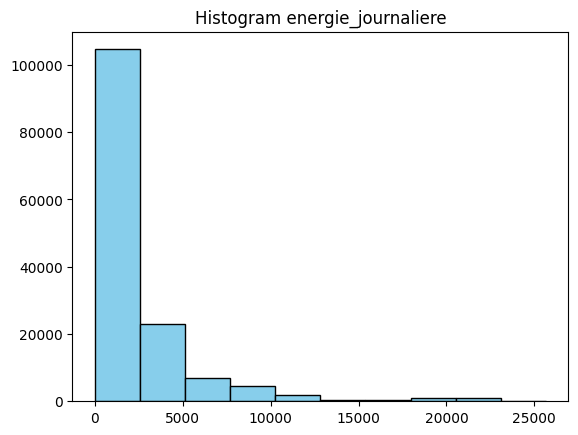

In [74]:
x = soutirages['energie_journaliere'].dropna()
counts, bins = np.histogram(x)
plt.hist(bins[:-1], bins, weights=counts, color="skyblue", edgecolor="black")
plt.title("Histogram energie_journaliere")

## Analyse visuelle

In [99]:
# Configuration du style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

dates = soutirages['date_de_la_courbe']
energie = soutirages['energie_journaliere']

# ÉTAPE 1: Préparation des données
def prepare_energy_data(soutirages):
    """
    Prépare les données pour l'analyse temporelle
    """
    df = soutirages.copy()
    df['date_de_la_courbe'] = pd.to_datetime(df['date_de_la_courbe'])
    df = df.sort_values('date_de_la_courbe')
    
    # Extraction des composantes temporelles
    df['annee'] = df['date_de_la_courbe'].dt.year   # e.g., 2020
    df['mois'] = df['date_de_la_courbe'].dt.month # e.g., 1-12
    df['jour_semaine'] = df['date_de_la_courbe'].dt.dayofweek # 0=Mon, 6=Sun
    df['jour_annee'] = df['date_de_la_courbe'].dt.dayofyear # 1-365/366
    df['trimestre'] = df['date_de_la_courbe'].dt.quarter # 1-4
    
    # Labels pour les jours de la semaine
    df['nom_jour'] = df['date_de_la_courbe'].dt.day_name()
    df['nom_mois'] = df['date_de_la_courbe'].dt.month_name()
    
    return df

# ÉTAPE 2: Visualisations améliorées
def create_comprehensive_energy_analysis(df):
    """
    Crée une analyse complète de la consommation énergétique
    """
    
    # Configuration de la figure avec subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Tendance générale avec moyennes mobiles
    ax1 = plt.subplot(3, 3, (1, 3))
    
    # Ligne originale (transparente)
    plt.plot(df['date_de_la_courbe'], df['energie_journaliere'], 
             alpha=0.3, color='lightblue', linewidth=0.5)
    
    # Moyennes mobiles
    df['MA_7'] = df['energie_journaliere'].rolling(window=7).mean() # 7-day MA
    df['MA_30'] = df['energie_journaliere'].rolling(window=30).mean() # 30-day MA
    df['MA_365'] = df['energie_journaliere'].rolling(window=365).mean() # 365-day MA
    
    plt.plot(df['date_de_la_courbe'], df['MA_7'], label='Moyenne 7j', linewidth=1)
    plt.plot(df['date_de_la_courbe'], df['MA_30'], label='Moyenne 30j', linewidth=2)
    plt.plot(df['date_de_la_courbe'], df['MA_365'], label='Tendance annuelle', linewidth=3)
    
    plt.title('Évolution de la consommation énergétique avec tendances', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Énergie (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Distribution par mois (boxplot)
    ax2 = plt.subplot(3, 3, 4)
    monthly_data = [df[df['mois'] == m]['energie_journaliere'].values for m in range(1, 13)]
    months = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
              'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
    
    bp = plt.boxplot(monthly_data, labels=months, patch_artist=True)
    colors = plt.cm.viridis(np.linspace(0, 1, 12))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.title('Distribution mensuelle')
    plt.xticks(rotation=45)
    plt.ylabel('Énergie (kWh)')
    
    # 3. Heatmap mensuelle
    ax3 = plt.subplot(3, 3, 5)
    pivot_month_year = df.groupby(['annee', 'mois'])['energie_journaliere'].mean().unstack()
    sns.heatmap(pivot_month_year, annot=True, fmt='.0f', cmap='YlOrRd', 
                xticklabels=months, cbar_kws={'label': 'Énergie moyenne (kWh)'})
    plt.title('Heatmap année-mois')
    plt.ylabel('Année')
    
    # 4. Distribution par jour de la semaine
    ax4 = plt.subplot(3, 3, 6)
    daily_avg = df.groupby('nom_jour')['energie_journaliere'].agg(['mean', 'std'])
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_avg = daily_avg.reindex(days_order)
    
    x_pos = np.arange(len(days_order))
    plt.bar(x_pos, daily_avg['mean'], yerr=daily_avg['std'], 
            capsize=5, alpha=0.8, color='skyblue', edgecolor='navy')
    plt.xticks(x_pos, ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'], rotation=45)
    plt.title('Consommation par jour de la semaine')
    plt.ylabel('Énergie moyenne (kWh)')
    
    # 5. Profil saisonnier
    ax5 = plt.subplot(3, 3, 7)
    seasonal_profile = df.groupby('jour_annee')['energie_journaliere'].mean()
    plt.plot(seasonal_profile.index, seasonal_profile.values, color='green', linewidth=2)
    plt.title('Profil saisonnier annuel')
    plt.xlabel('Jour de l\'année')
    plt.ylabel('Énergie moyenne (kWh)')
    plt.grid(True, alpha=0.3)
    
    # 6. Distribution globale
    ax6 = plt.subplot(3, 3, 8)
    plt.hist(df['energie_journaliere'], bins=50, alpha=0.7, color='coral', edgecolor='black')
    plt.axvline(df['energie_journaliere'].mean(), color='red', linestyle='--', 
                label=f'Moyenne: {df["energie_journaliere"].mean():.0f} kWh')
    plt.axvline(df['energie_journaliere'].median(), color='blue', linestyle='--', 
                label=f'Médiane: {df["energie_journaliere"].median():.0f} kWh')
    plt.title('Distribution de la consommation')
    plt.xlabel('Énergie (kWh)')
    plt.ylabel('Fréquence')
    plt.legend()
    
    # 7. Statistiques par trimestre
    ax7 = plt.subplot(3, 3, 9)
    quarterly_stats = df.groupby('trimestre')['energie_journaliere'].agg(['mean', 'median', 'std'])
    x_pos = np.arange(len(quarterly_stats))
    width = 0.25
    
    plt.bar(x_pos - width, quarterly_stats['mean'], width, label='Moyenne', alpha=0.8)
    plt.bar(x_pos, quarterly_stats['median'], width, label='Médiane', alpha=0.8)
    plt.bar(x_pos + width, quarterly_stats['std'], width, label='Écart-type', alpha=0.8)
    
    plt.xticks(x_pos, ['Q1', 'Q2', 'Q3', 'Q4'])
    plt.title('Statistiques trimestrielles')
    plt.ylabel('Énergie (kWh)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques descriptives
    print("=== ANALYSE STATISTIQUE DE LA CONSOMMATION ÉNERGÉTIQUE ===\n")
    
    print(" Statistiques globales:")
    print(f"   • Moyenne: {df['energie_journaliere'].mean():.2f} kWh")
    print(f"   • Médiane: {df['energie_journaliere'].median():.2f} kWh")
    print(f"   • Écart-type: {df['energie_journaliere'].std():.2f} kWh")
    print(f"   • Min: {df['energie_journaliere'].min():.2f} kWh")
    print(f"   • Max: {df['energie_journaliere'].max():.2f} kWh")
    print(f"   • Coefficient de variation: {(df['energie_journaliere'].std()/df['energie_journaliere'].mean()*100):.2f}%")
    
    print(f"\n Période d'analyse:")
    print(f"   • Du {df['date_de_la_courbe'].min().strftime('%d/%m/%Y')} au {df['date_de_la_courbe'].max().strftime('%d/%m/%Y')}")
    print(f"   • Nombre de jours: {len(df)}")
    
    print(f"\n Tendances saisonnières:")
    seasonal_max = df.groupby('mois')['energie_journaliere'].mean().idxmax()
    seasonal_min = df.groupby('mois')['energie_journaliere'].mean().idxmin()
    print(f"   • Pic de consommation: mois {seasonal_max} ({months[seasonal_max-1]})")
    print(f"   • Consommation minimale: mois {seasonal_min} ({months[seasonal_min-1]})")
    
    return df

C:\Users\kadas\AppData\Local\Temp\ipykernel_24536\2604359157.py:67: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



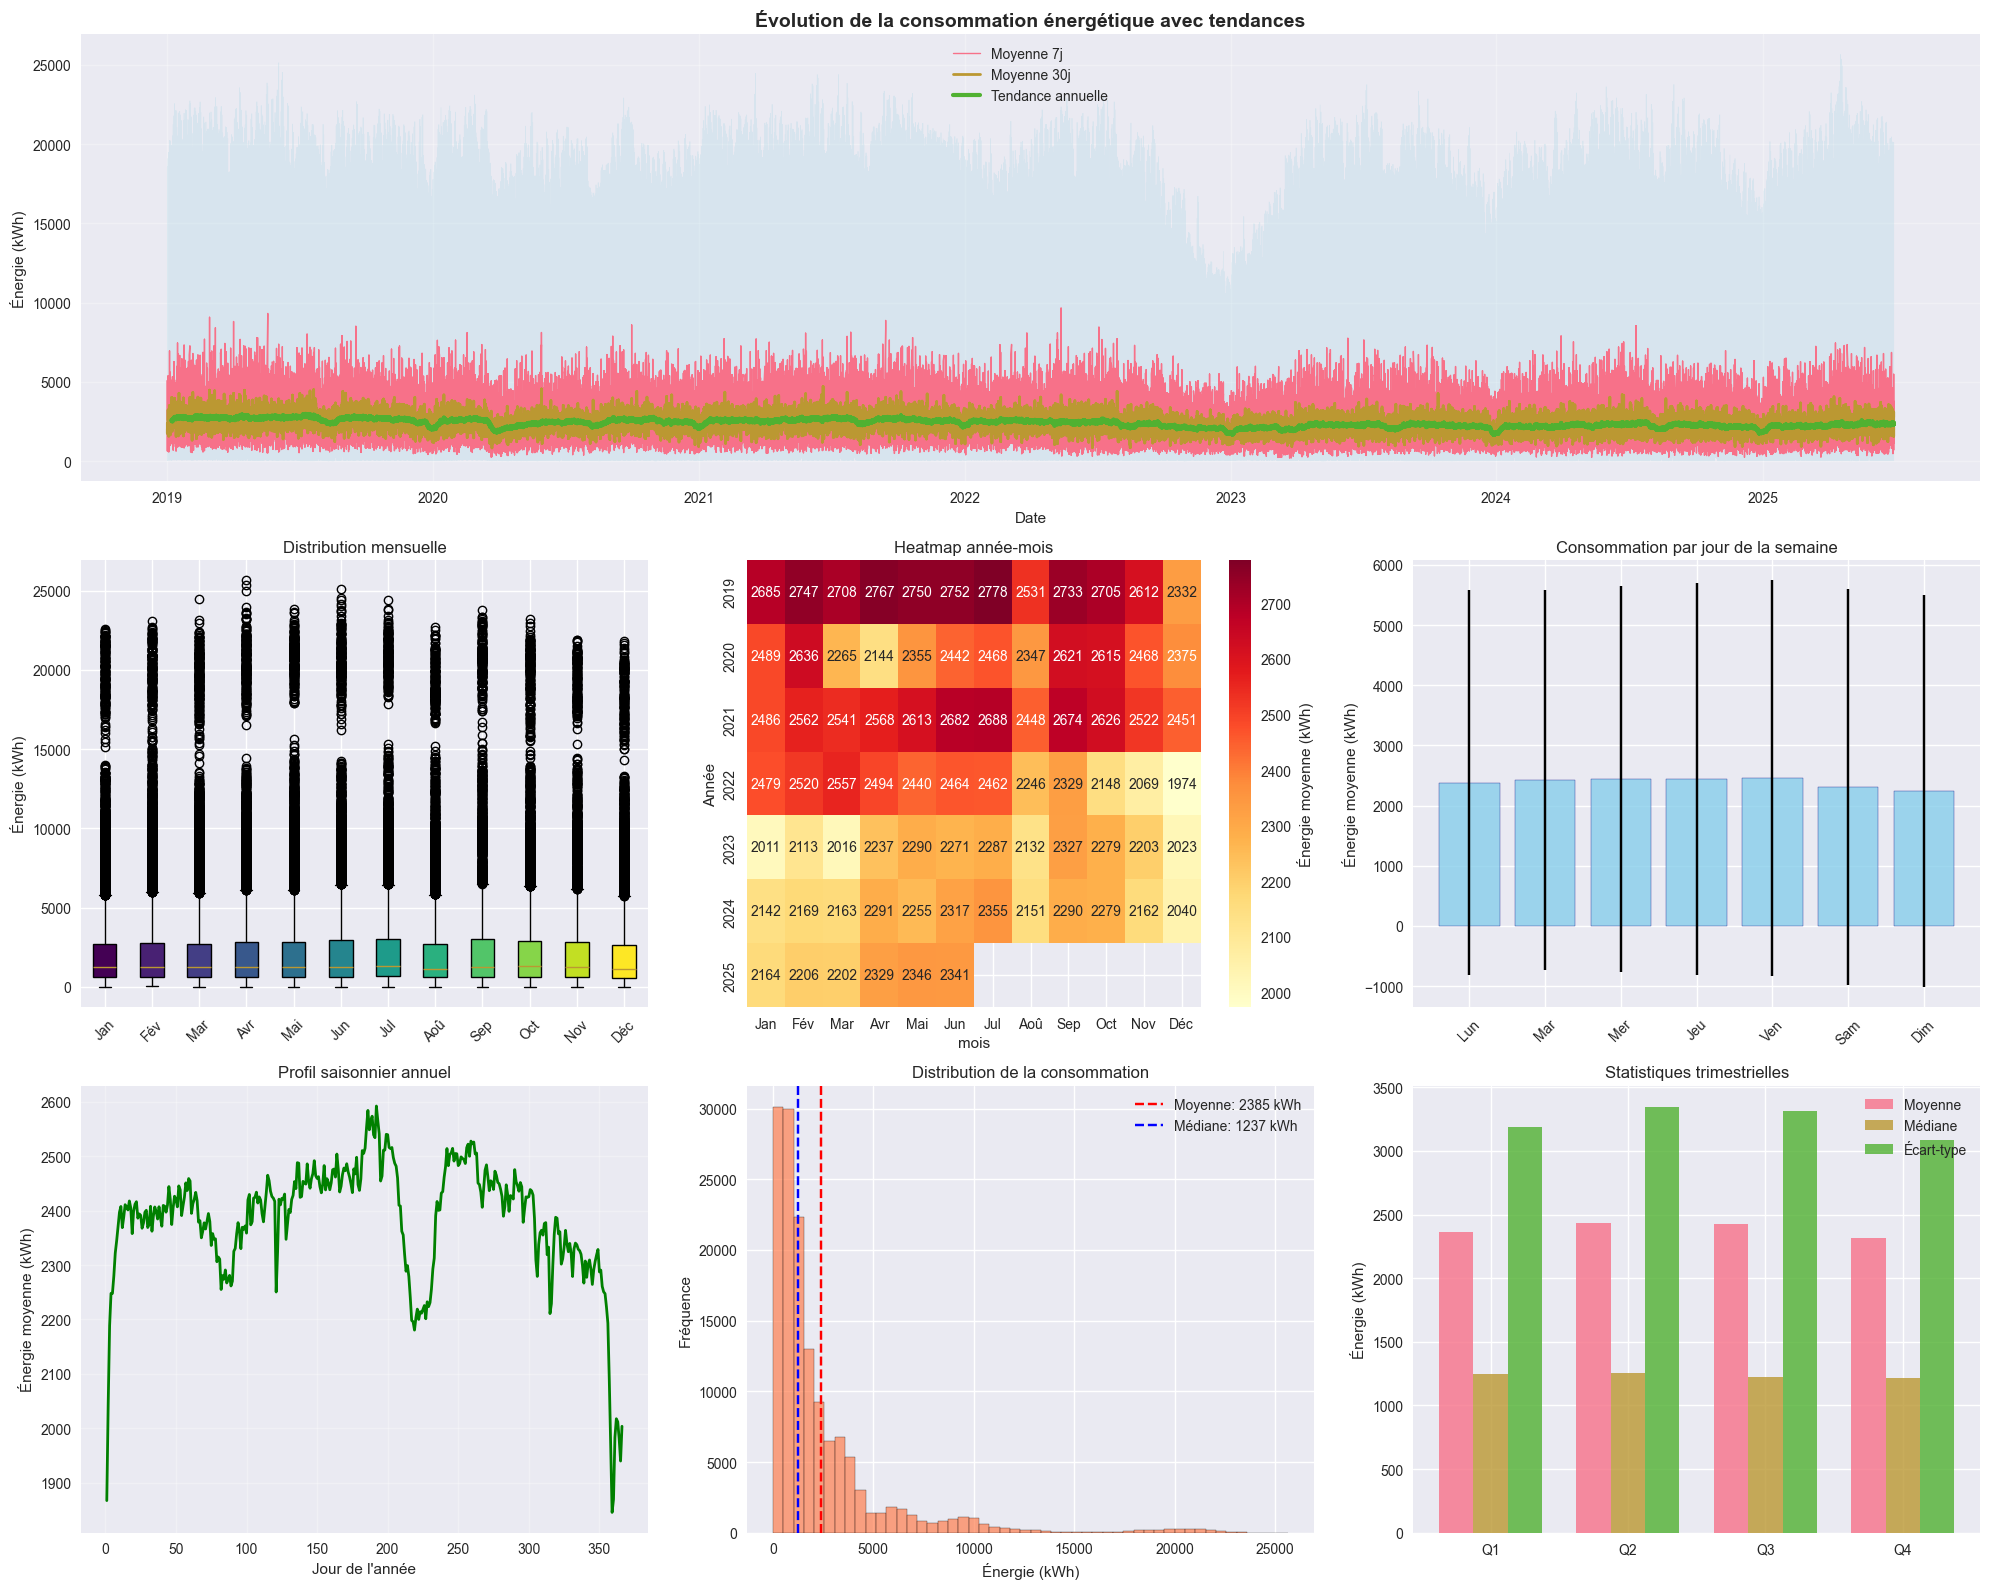

=== ANALYSE STATISTIQUE DE LA CONSOMMATION ÉNERGÉTIQUE ===

 Statistiques globales:
   • Moyenne: 2385.32 kWh
   • Médiane: 1236.67 kWh
   • Écart-type: 3237.13 kWh
   • Min: 0.05 kWh
   • Max: 25651.71 kWh
   • Coefficient de variation: 135.71%

 Période d'analyse:
   • Du 01/01/2019 au 30/06/2025
   • Nombre de jours: 143846

 Tendances saisonnières:
   • Pic de consommation: mois 7 (Jul)
   • Consommation minimale: mois 12 (Déc)


,date_de_la_courbe,code_insee_region,region,secteur_activite_economique,code_tension,libelle_tension,00h00,00h30,01h00,01h30,...,annee,mois,jour_semaine,jour_annee,trimestre,nom_jour,nom_mois,MA_7,MA_30,MA_365
38740,2019-01-01,28,Normandie,Grande Industrie,4,90 kV,232.611000,232.654000,232.130000,231.909000,...,2019,1,1,1,1,Tuesday,January,NaN,NaN,NaN
30626,2019-01-01,75,Nouvelle-Aquitaine,Autre,4,90 kV,38.596000,39.871000,38.315000,41.236000,...,2019,1,1,1,1,Tuesday,January,NaN,NaN,NaN
46124,2019-01-01,44,Grand Est,Autre,3,63 kV,106.855000,106.905000,106.794000,105.751000,...,2019,1,1,1,1,Tuesday,January,NaN,NaN,NaN
43688,2019-01-01,32,Hauts-de-France,Tertiaire,4,90 kV,2.690000,2.732000,4.381000,3.246000,...,2019,1,1,1,1,Tuesday,January,NaN,NaN,NaN
51944,2019-01-01,75,Nouvelle-Aquitaine,Tertiaire,3,63 kV,7.242000,6.714000,6.410000,6.402000,...,2019,1,1,1,1,Tuesday,January,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86590,2025-06-30,84,Auvergne-Rhône-Alpes,Autre,6,225 kV,109.773837,109.568985,109.408963,109.352863,...,2025,6,0,181,2,Monday,June,2602.005850,2857.061598,2366.101621
86592,2025-06-30,11,Île-de-France,Autre,4,90 kV,64.414500,64.473500,64.070500,63.918000,...,2025,6,0,181,2,Monday,June,2711.186600,2874.691232,2369.245551
13926,2025-06-30,53,Bretagne,Autre,3,63 kV,28.639000,27.886500,27.955000,28.561000,...,2025,6,0,181,2,Monday,June,1172.315991,2837.948823,2315.927577
86596,2025-06-30,27,Bourgogne-Franche-Comté,Grande Industrie,3,63 kV,37.644904,37.481340,38.249404,36.506372,...,2025,6,0,181,2,Monday,June,1171.900033,2845.113392,2302.688733


In [100]:
df = prepare_energy_data(soutirages)
create_comprehensive_energy_analysis(df)

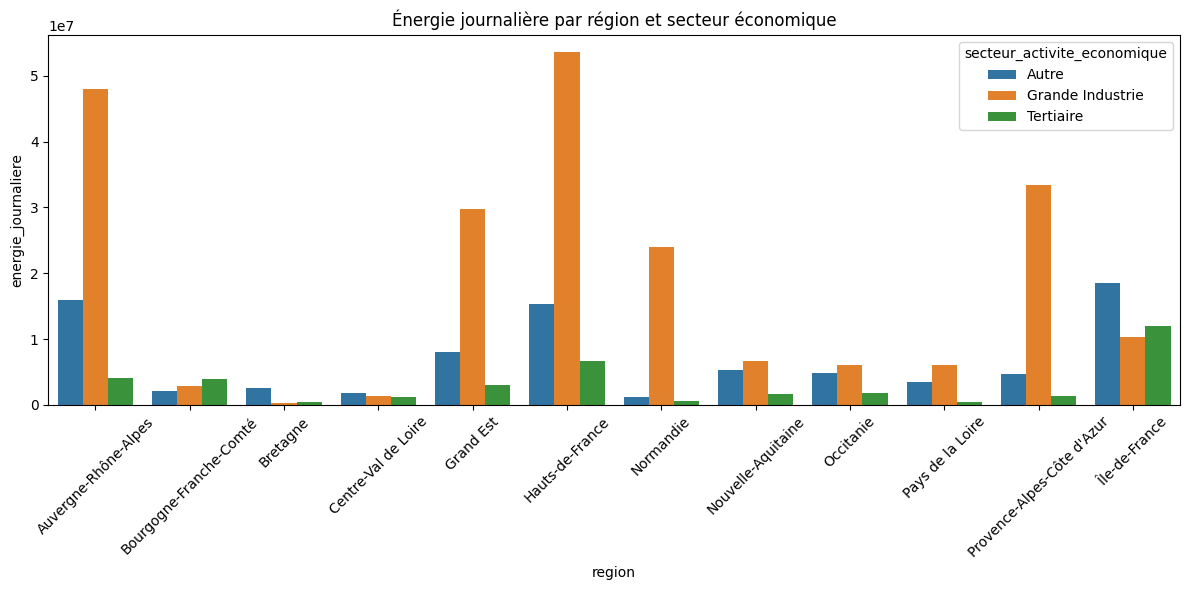

In [76]:
grouped = soutirages.groupby(["region","secteur_activite_economique"])["energie_journaliere"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='region', y='energie_journaliere', hue='secteur_activite_economique')
plt.title("Énergie journalière par région et secteur économique")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


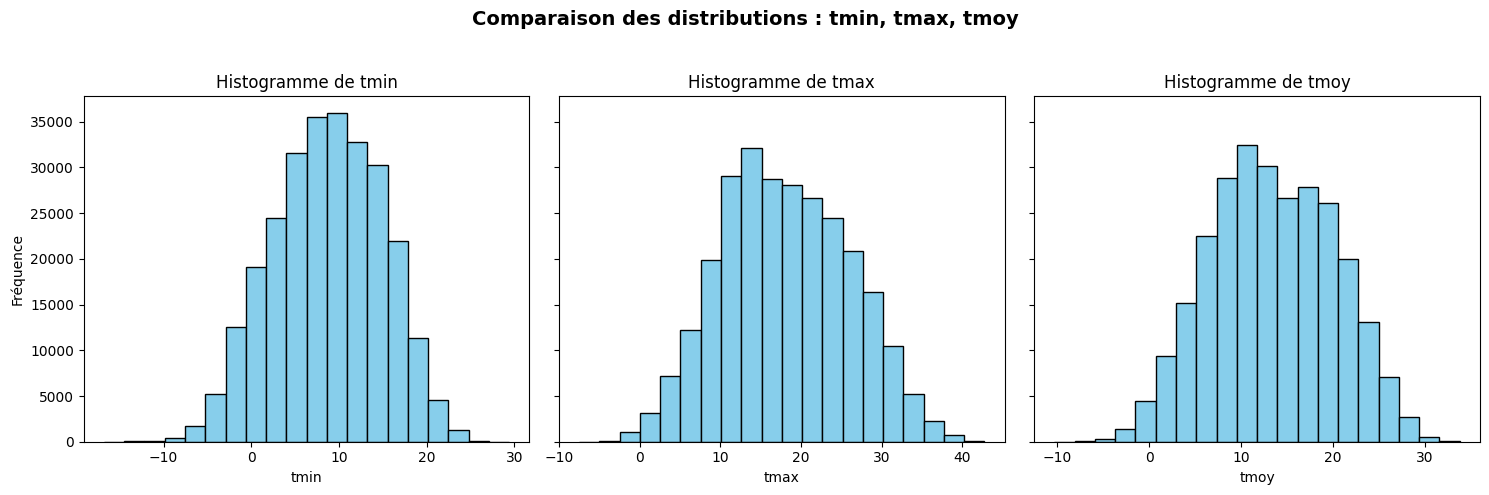

In [40]:
# Colonnes à comparer
cols = ["tmin", "tmax", "tmoy"]

# Créer une figure avec 3 sous-graphes côte à côte
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, col in enumerate(cols):
    y = temperatures[col].dropna()
    counts, bins = np.histogram(y, bins=20) 
    axes[i].hist(bins[:-1], bins, weights=counts, color="skyblue", edgecolor="black")
    axes[i].set_title(f"Histogramme de {col}", fontsize=12)
    axes[i].set_xlabel(col)
    if i == 0:
        axes[i].set_ylabel("Fréquence")

plt.suptitle("Comparaison des distributions : tmin, tmax, tmoy", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
soutirages["region"].unique() 

array(['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté',
       'Hauts-de-France', 'Nouvelle-Aquitaine',
       "Provence-Alpes-Côte d'Azur", 'Grand Est', 'Île-de-France',
       'Normandie', 'Occitanie', 'Bretagne', 'Centre-Val de Loire',
       'Pays de la Loire'], dtype=object)

In [108]:
soutirages.head(2)

,date_de_la_courbe,code_insee_region,region,secteur_activite_economique,code_tension,libelle_tension,00h00,00h30,01h00,01h30,...,20h30,21h00,21h30,22h00,22h30,23h00,23h30,nombre_de_points_de_soutirage,energie_journaliere,qualite
0,2025-05-01,84,Auvergne-Rhône-Alpes,Autre,6,225 kV,102.584173,102.023702,102.354603,102.072969,...,106.096178,105.174566,105.407989,105.556989,103.945831,104.720358,104.637586,8,2486.519638,Consolidée
1,2025-05-01,27,Bourgogne-Franche-Comté,Autre,3,63 kV,23.561200,23.595685,22.897904,22.847578,...,22.696355,23.016484,24.264011,24.109439,25.498268,25.543942,25.623394,11,565.227528,Consolidée


In [112]:
temperatures.head(2)

,date_obs,code_insee_departement,departement,tmin,tmax,tmoy
0,2025-06-01,90,Territoire de Belfort,16.3,27.8,22.05
1,2025-06-01,57,Moselle,16.0,24.1,20.05


In [118]:
# Table de correspondance Code INSEE région → Nom
mapping_region = {
    "84": "Auvergne-Rhône-Alpes",
    "27": "Bourgogne-Franche-Comté",
    "53": "Bretagne",
    "24": "Centre-Val de Loire",
    "94": "Corse",
    "44": "Grand Est",
    "32": "Hauts-de-France",
    "11": "Île-de-France",
    "28": "Normandie",
    "75": "Nouvelle-Aquitaine",
    "76": "Occitanie",
    "52": "Pays de la Loire",
    "93": "Provence-Alpes-Côte d'Azur"
}

# Table officielle départements → régions (simplifiée)
dep_to_reg = {
    "01": "84", "59": "32", "75": "11", "33": "75", "13": "93"
}

# Ajouter la colonne code région
temperatures["code_region"] = temperatures["code_insee_departement"].map(dep_to_reg)

# Ajouter la colonne libellé de région
temperatures["region"] = temperatures["code_region"].map(mapping_region)

temperatures


,date_obs,code_insee_departement,departement,tmin,tmax,tmoy,code_region,region
0,2025-06-01,90,Territoire de Belfort,16.30,27.80,22.05,NaN,NaN
1,2025-06-01,57,Moselle,16.00,24.10,20.05,NaN,NaN
2,2025-06-01,06,Alpes-Maritimes,17.00,24.83,20.92,NaN,NaN
3,2025-06-02,08,Ardennes,11.00,21.50,16.25,NaN,NaN
4,2025-06-02,69,Rhône,17.80,22.55,20.18,NaN,NaN
...,...,...,...,...,...,...,...,...
268795,2025-08-05,51,Marne,17.15,23.05,20.10,NaN,NaN
268796,2025-08-06,05,Hautes-Alpes,13.60,28.70,21.15,NaN,NaN
268797,2025-08-06,51,Marne,9.00,23.00,16.00,NaN,NaN
268798,2025-08-06,46,Lot,10.10,28.80,19.45,NaN,NaN


In [119]:
temperatures["code_region"].unique()

array([nan, '11', '32', '93', '75', '84'], dtype=object)